# Baseline Results

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score, roc_curve
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, TimeDistributed, Conv1D, BatchNormalization, MaxPooling1D, Bidirectional, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.initializers import Constant
from keras.layers.advanced_activations import PReLU

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, get_class_names, load_fusioned_dataset

In [2]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
)

In [3]:
epochs, batch_size = 25, 32
kf = KFold(n_splits=3, shuffle=True, random_state=48)

cnn_auc = []
rnn_auc = []

## 1. Unimodal Body Modality (Skeleton)

### Dataset

In [4]:
X_train, X_test, y_train, y_test = load_dataset('skeleton')
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(812, 1, 350, 35) (812, 7)
(245, 1, 350, 35) (245, 7)


In [5]:
classes = get_class_names('skeleton')
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

No Pain               403
LowerBody Mild        164
LowerBody Moderate    103
UpperBody Mild         75
UpperBody Moderate     64
UpperBody Severe        2
LowerBody Severe        1
dtype: int64

In [6]:
nopain, lbmild, lbmod, ubmild, ubmod, ubsevere, lbsevere = np.sum(y, axis=0)
total = nopain + ubmild + lbmod + lbmild + ubmod + ubsevere + lbsevere

weight_for_lbmild = (1 / lbmild) * (total / 2.0)
weight_for_lbmod = (1 / lbmod) * (total / 2.0)
weight_for_nopain = (1 / nopain) * (total / 2.0)
weight_for_ubmild = (1 / ubmild) * (total / 2.0)
weight_for_ubmod = (1 / ubmod) * (total / 2.0)
weight_for_lbsevere = (1 / lbsevere) * (total / 2.0)
weight_for_ubsevere = (1 / ubsevere) * (total / 2.0)

class_weight = {0: weight_for_nopain, 1: weight_for_lbmild, 2: weight_for_lbmod, 3: weight_for_ubmild, 4: weight_for_ubmod, 5: weight_for_ubsevere, 6: weight_for_lbsevere}

print('Weight for class "No Pain": {:.2f}'.format(weight_for_nopain))
print('Weight for class "Lower Body Mild Pain": {:.2f}'.format(weight_for_lbmild))
print('Weight for class "Lower Body Moderate Pain": {:.2f}'.format(weight_for_lbmod))
print('Weight for class "Upper Body Mild Pain": {:.2f}'.format(weight_for_ubmild))
print('Weight for class "Upper Body Moderate Pain": {:.2f}'.format(weight_for_ubmod))
print('Weight for class "Upper Body Severe Pain": {:.2f}'.format(weight_for_ubsevere))
print('Weight for class "Lower Body Severe Pain": {:.2f}'.format(weight_for_lbsevere))

Weight for class "No Pain": 2.48
Weight for class "Lower Body Mild Pain": 3.94
Weight for class "Lower Body Moderate Pain": 406.00
Weight for class "Upper Body Mild Pain": 1.01
Weight for class "Upper Body Moderate Pain": 5.41
Weight for class "Upper Body Severe Pain": 6.34
Weight for class "Lower Body Severe Pain": 203.00


### CNN + Bidirectional LSTM

In [7]:
class CNNLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(128, activation='relu'))(flatten)
        dense = Dense(448, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 6s - loss: 297.5305 - accuracy: 0.2181 - auc: 0.5532 - precision: 0.2171 - recall: 0.2163 - f1_score: 0.1298 - val_loss: 30.8709 - val_accuracy: 0.1476 - val_auc: 0.5212 - val_precision: 0.1476 - val_recall: 0.1476 - val_f1_score: 0.0457 - 6s/epoch - 382ms/step
Epoch 2/25
17/17 - 1s - loss: 303.3524 - accuracy: 0.1165 - auc: 0.4877 - precision: 0.1165 - recall: 0.1165 - f1_score: 0.0854 - val_loss: 219.6538 - val_accuracy: 0.0406 - val_auc: 0.4195 - val_precision: 0.0406 - val_recall: 0.0406 - val_f1_score: 0.0189 - 543ms/epoch - 32ms/step
Epoch 3/25
17/17 - 1s - loss: 397.7372 - accuracy: 0.1460 - auc: 0.4951 - precision: 0.1460 - recall: 0.1460 - f1_score: 0.0811 - val_loss: 40.4247 - val_accuracy: 0.1218 - val_auc: 0.5003 - val_precision: 0.1218 - val_recall: 0.1218 - val_f1_score: 0.0352 - 536ms/epoch - 32ms/step
Epoch 4/25
17/17 - 1s - loss: 434.5714 - accuracy: 0.1590 - auc: 0.5197 - precision: 0.1590 - recall: 0.1590 - f1_score: 0.0829 - val_loss: 54.4118 - va

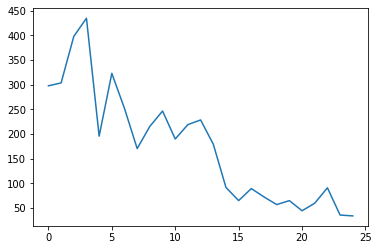

Epoch 1/25
17/17 - 3s - loss: 202.1157 - accuracy: 0.1738 - auc_1: 0.5166 - precision_1: 0.1738 - recall_1: 0.1738 - f1_score: 0.1186 - val_loss: 37.7349 - val_accuracy: 0.0443 - val_auc_1: 0.3913 - val_precision_1: 0.0443 - val_recall_1: 0.0443 - val_f1_score: 0.0228 - 3s/epoch - 197ms/step
Epoch 2/25
17/17 - 1s - loss: 86.5484 - accuracy: 0.1645 - auc_1: 0.5313 - precision_1: 0.1654 - recall_1: 0.1645 - f1_score: 0.0961 - val_loss: 14.5595 - val_accuracy: 0.0775 - val_auc_1: 0.4611 - val_precision_1: 0.0775 - val_recall_1: 0.0775 - val_f1_score: 0.0205 - 689ms/epoch - 41ms/step
Epoch 3/25
17/17 - 1s - loss: 31.4963 - accuracy: 0.1978 - auc_1: 0.6176 - precision_1: 0.1947 - recall_1: 0.1774 - f1_score: 0.1283 - val_loss: 3.1365 - val_accuracy: 0.4207 - val_auc_1: 0.7533 - val_precision_1: 0.4474 - val_recall_1: 0.3764 - val_f1_score: 0.1330 - 687ms/epoch - 40ms/step
Epoch 4/25
17/17 - 1s - loss: 10.8240 - accuracy: 0.2274 - auc_1: 0.6503 - precision_1: 0.2468 - recall_1: 0.2163 - f1_s

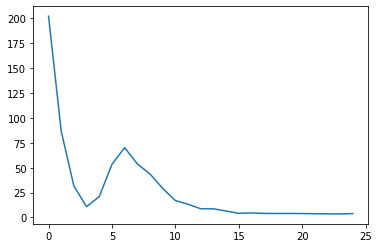

Epoch 1/25
17/17 - 3s - loss: 510.3296 - accuracy: 0.1734 - auc_2: 0.5170 - precision_2: 0.1734 - recall_2: 0.1734 - f1_score: 0.1059 - val_loss: 192.6125 - val_accuracy: 0.0000e+00 - val_auc_2: 0.4167 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_f1_score: 0.0000e+00 - 3s/epoch - 185ms/step
Epoch 2/25
17/17 - 1s - loss: 405.9337 - accuracy: 0.0941 - auc_2: 0.4669 - precision_2: 0.0941 - recall_2: 0.0941 - f1_score: 0.0642 - val_loss: 91.9264 - val_accuracy: 0.1222 - val_auc_2: 0.4830 - val_precision_2: 0.1222 - val_recall_2: 0.1222 - val_f1_score: 0.0567 - 694ms/epoch - 41ms/step
Epoch 3/25
17/17 - 1s - loss: 178.8154 - accuracy: 0.1402 - auc_2: 0.4949 - precision_2: 0.1402 - recall_2: 0.1402 - f1_score: 0.0941 - val_loss: 45.9860 - val_accuracy: 0.0333 - val_auc_2: 0.4162 - val_precision_2: 0.0333 - val_recall_2: 0.0333 - val_f1_score: 0.0255 - 680ms/epoch - 40ms/step
Epoch 4/25
17/17 - 1s - loss: 137.8146 - accuracy: 0.1919 - auc_2: 0.5294 - precision_2: 0.1926 - re

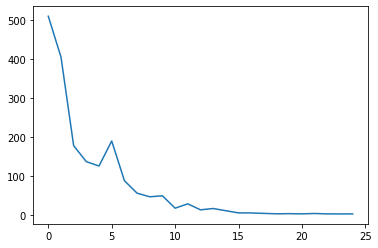

In [8]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_multiclass_body_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_multiclass_body_model.train(X_train, y_train, X_val, y_val, epochs, batch_size, class_weight)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on holdout set

In [9]:
y_pred = cnnlstm_multiclass_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_multiclass_body_model.evaluate(X_test, y_test)
cnn_auc.append(round(auc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 21.63% 
Balanced Accuracy: 15.37% 
ROC/AUC: 0.69 
Precision: 0.23 
Recall: 0.08 
F1 score: 0.12


### RCNN

In [10]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(448, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results
    
    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 2s - loss: 56.5175 - accuracy: 0.2384 - auc_3: 0.5982 - precision_3: 0.2406 - recall_3: 0.2237 - f1_score: 0.1446 - val_loss: 225.5571 - val_accuracy: 0.0037 - val_auc_3: 0.4158 - val_precision_3: 0.0037 - val_recall_3: 0.0037 - val_f1_score: 0.0011 - 2s/epoch - 107ms/step
Epoch 2/25
17/17 - 0s - loss: 42.4473 - accuracy: 0.1312 - auc_3: 0.4873 - precision_3: 0.1335 - recall_3: 0.1312 - f1_score: 0.0931 - val_loss: 167.3228 - val_accuracy: 0.1292 - val_auc_3: 0.4849 - val_precision_3: 0.1292 - val_recall_3: 0.1292 - val_f1_score: 0.0737 - 400ms/epoch - 24ms/step
Epoch 3/25
17/17 - 0s - loss: 16.0779 - accuracy: 0.3641 - auc_3: 0.6622 - precision_3: 0.3748 - recall_3: 0.3512 - f1_score: 0.3993 - val_loss: 57.6703 - val_accuracy: 0.1550 - val_auc_3: 0.4973 - val_precision_3: 0.1550 - val_recall_3: 0.1550 - val_f1_score: 0.0681 - 422ms/epoch - 25ms/step
Epoch 4/25
17/17 - 0s - loss: 8.4243 - accuracy: 0.3845 - auc_3: 0.7236 - precision_3: 0.3987 - recall_3: 0.3420 - f1_

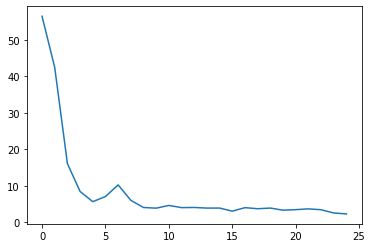

Epoch 1/25
17/17 - 2s - loss: 40.3130 - accuracy: 0.2329 - auc_4: 0.5700 - precision_4: 0.2305 - recall_4: 0.2181 - f1_score: 0.1498 - val_loss: 71.3200 - val_accuracy: 0.1292 - val_auc_4: 0.4851 - val_precision_4: 0.1292 - val_recall_4: 0.1292 - val_f1_score: 0.0591 - 2s/epoch - 100ms/step
Epoch 2/25
17/17 - 0s - loss: 10.7498 - accuracy: 0.2551 - auc_4: 0.6491 - precision_4: 0.2685 - recall_4: 0.2348 - f1_score: 0.2009 - val_loss: 34.3480 - val_accuracy: 0.1697 - val_auc_4: 0.5082 - val_precision_4: 0.1697 - val_recall_4: 0.1697 - val_f1_score: 0.0633 - 385ms/epoch - 23ms/step
Epoch 3/25
17/17 - 0s - loss: 7.0740 - accuracy: 0.3697 - auc_4: 0.7449 - precision_4: 0.3868 - recall_4: 0.3346 - f1_score: 0.2634 - val_loss: 9.7521 - val_accuracy: 0.1808 - val_auc_4: 0.5544 - val_precision_4: 0.1856 - val_recall_4: 0.1808 - val_f1_score: 0.0999 - 377ms/epoch - 22ms/step
Epoch 4/25
17/17 - 0s - loss: 7.5548 - accuracy: 0.3882 - auc_4: 0.7500 - precision_4: 0.4017 - recall_4: 0.3586 - f1_scor

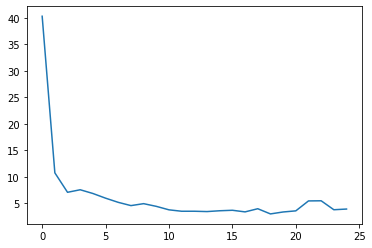

Epoch 1/25
17/17 - 2s - loss: 111.3108 - accuracy: 0.2638 - auc_5: 0.6249 - precision_5: 0.2724 - recall_5: 0.2528 - f1_score: 0.1551 - val_loss: 36.4750 - val_accuracy: 0.4444 - val_auc_5: 0.7176 - val_precision_5: 0.4494 - val_recall_5: 0.4444 - val_f1_score: 0.1514 - 2s/epoch - 97ms/step
Epoch 2/25
17/17 - 0s - loss: 55.1283 - accuracy: 0.1771 - auc_5: 0.5500 - precision_5: 0.1756 - recall_5: 0.1697 - f1_score: 0.1222 - val_loss: 89.6563 - val_accuracy: 0.1148 - val_auc_5: 0.4836 - val_precision_5: 0.1148 - val_recall_5: 0.1148 - val_f1_score: 0.0296 - 321ms/epoch - 19ms/step
Epoch 3/25
17/17 - 0s - loss: 29.3305 - accuracy: 0.3173 - auc_5: 0.6717 - precision_5: 0.3138 - recall_5: 0.2970 - f1_score: 0.2258 - val_loss: 39.9142 - val_accuracy: 0.0815 - val_auc_5: 0.4653 - val_precision_5: 0.0815 - val_recall_5: 0.0815 - val_f1_score: 0.0388 - 312ms/epoch - 18ms/step
Epoch 4/25
17/17 - 0s - loss: 10.7921 - accuracy: 0.3672 - auc_5: 0.7412 - precision_5: 0.3802 - recall_5: 0.3542 - f1_s

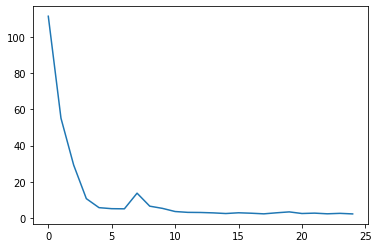

In [11]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_multiclass_body_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_multiclass_body_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [12]:
y_pred = rcnn_multiclass_body_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_multiclass_body_model.evaluate(X_test, y_test)
rnn_auc.append(round(auc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 17.14% 
Balanced Accuracy: 15.37% 
ROC/AUC: 0.52 
Precision: 0.16 
Recall: 0.16 
F1 score: 0.10


## 2. Unimodal Face Modality (Action Units + Head Pose)

### Dataset

In [13]:
X_train, X_test, y_train, y_test = load_dataset('AUs')
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(782, 1, 350, 25) (782, 7)
(238, 1, 350, 25) (238, 7)


In [14]:
classes = get_class_names('AUs')
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

No Pain               387
LowerBody Mild        157
LowerBody Moderate    100
UpperBody Mild         74
UpperBody Moderate     61
UpperBody Severe        2
LowerBody Severe        1
dtype: int64

In [15]:
nopain, lbmild, lbmod, ubmild, ubmod, ubsevere, lbsevere = np.sum(y, axis=0)
total = nopain + ubmild + lbmod + lbmild + ubmod + ubsevere + lbsevere

weight_for_lbmild = (1 / lbmild) * (total / 2.0)
weight_for_lbmod = (1 / lbmod) * (total / 2.0)
weight_for_nopain = (1 / nopain) * (total / 2.0)
weight_for_ubmild = (1 / ubmild) * (total / 2.0)
weight_for_ubmod = (1 / ubmod) * (total / 2.0)
weight_for_lbsevere = (1 / lbsevere) * (total / 2.0)
weight_for_ubsevere = (1 / ubsevere) * (total / 2.0)

class_weight = {0: weight_for_nopain, 1: weight_for_lbmild, 2: weight_for_lbmod, 3: weight_for_ubmild, 4: weight_for_ubmod, 5: weight_for_ubsevere, 6: weight_for_lbsevere}

print('Weight for class "No Pain": {:.2f}'.format(weight_for_nopain))
print('Weight for class "Lower Body Mild Pain": {:.2f}'.format(weight_for_lbmild))
print('Weight for class "Lower Body Moderate Pain": {:.2f}'.format(weight_for_lbmod))
print('Weight for class "Upper Body Mild Pain": {:.2f}'.format(weight_for_ubmild))
print('Weight for class "Upper Body Moderate Pain": {:.2f}'.format(weight_for_ubmod))
print('Weight for class "Upper Body Severe Pain": {:.2f}'.format(weight_for_ubsevere))
print('Weight for class "Lower Body Severe Pain": {:.2f}'.format(weight_for_lbsevere))

Weight for class "No Pain": 2.49
Weight for class "Lower Body Mild Pain": 3.91
Weight for class "Lower Body Moderate Pain": 391.00
Weight for class "Upper Body Mild Pain": 1.01
Weight for class "Upper Body Moderate Pain": 5.28
Weight for class "Upper Body Severe Pain": 6.41
Weight for class "Lower Body Severe Pain": 195.50


### CNN + Bidirectional LSTM

In [16]:
class CNNLSTM():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(128, activation='relu'))(flatten)
        dense = Dense(448, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 3s - loss: 145413.2500 - accuracy: 0.3762 - auc_6: 0.6419 - precision_6: 0.3762 - recall_6: 0.3762 - f1_score: 0.1243 - val_loss: 58102.8047 - val_accuracy: 0.4981 - val_auc_6: 0.7072 - val_precision_6: 0.4981 - val_recall_6: 0.4981 - val_f1_score: 0.0955 - 3s/epoch - 191ms/step
Epoch 2/25
17/17 - 1s - loss: 121836.5781 - accuracy: 0.2860 - auc_6: 0.5837 - precision_6: 0.2860 - recall_6: 0.2860 - f1_score: 0.1019 - val_loss: 59853.9375 - val_accuracy: 0.1418 - val_auc_6: 0.4994 - val_precision_6: 0.1418 - val_recall_6: 0.1418 - val_f1_score: 0.0387 - 514ms/epoch - 30ms/step
Epoch 3/25
17/17 - 1s - loss: 136526.2344 - accuracy: 0.2092 - auc_6: 0.5464 - precision_6: 0.2092 - recall_6: 0.2092 - f1_score: 0.0954 - val_loss: 65367.4023 - val_accuracy: 0.0920 - val_auc_6: 0.4678 - val_precision_6: 0.0920 - val_recall_6: 0.0920 - val_f1_score: 0.0286 - 511ms/epoch - 30ms/step
Epoch 4/25
17/17 - 1s - loss: 68672.8125 - accuracy: 0.0480 - auc_6: 0.4434 - precision_6: 0.0480 -

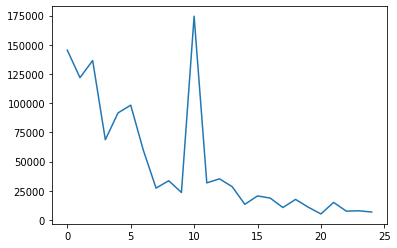

Epoch 1/25
17/17 - 3s - loss: 210754.6250 - accuracy: 0.3916 - auc_7: 0.6510 - precision_7: 0.3916 - recall_7: 0.3916 - f1_score: 0.1095 - val_loss: 76778.8828 - val_accuracy: 0.4904 - val_auc_7: 0.7027 - val_precision_7: 0.4904 - val_recall_7: 0.4904 - val_f1_score: 0.1036 - 3s/epoch - 179ms/step
Epoch 2/25
17/17 - 1s - loss: 310674.8438 - accuracy: 0.1958 - auc_7: 0.5317 - precision_7: 0.1958 - recall_7: 0.1958 - f1_score: 0.0728 - val_loss: 80773.8359 - val_accuracy: 0.1188 - val_auc_7: 0.4860 - val_precision_7: 0.1188 - val_recall_7: 0.1188 - val_f1_score: 0.0318 - 514ms/epoch - 30ms/step
Epoch 3/25
17/17 - 1s - loss: 106411.7656 - accuracy: 0.3033 - auc_7: 0.6015 - precision_7: 0.3033 - recall_7: 0.3033 - f1_score: 0.1151 - val_loss: 50400.3008 - val_accuracy: 0.4789 - val_auc_7: 0.6960 - val_precision_7: 0.4789 - val_recall_7: 0.4789 - val_f1_score: 0.0925 - 671ms/epoch - 39ms/step
Epoch 4/25
17/17 - 1s - loss: 426909.9688 - accuracy: 0.3359 - auc_7: 0.6158 - precision_7: 0.3359 

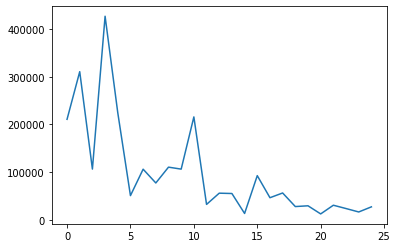

Epoch 1/25
17/17 - 3s - loss: 360920.5000 - accuracy: 0.1303 - auc_8: 0.4953 - precision_8: 0.1303 - recall_8: 0.1303 - f1_score: 0.0749 - val_loss: 55592.5820 - val_accuracy: 0.4308 - val_auc_8: 0.6788 - val_precision_8: 0.4308 - val_recall_8: 0.4308 - val_f1_score: 0.1042 - 3s/epoch - 180ms/step
Epoch 2/25
17/17 - 1s - loss: 271885.3125 - accuracy: 0.1667 - auc_8: 0.5155 - precision_8: 0.1667 - recall_8: 0.1667 - f1_score: 0.0893 - val_loss: 68015.7656 - val_accuracy: 0.0885 - val_auc_8: 0.4672 - val_precision_8: 0.0885 - val_recall_8: 0.0885 - val_f1_score: 0.0390 - 510ms/epoch - 30ms/step
Epoch 3/25
17/17 - 1s - loss: 266632.6250 - accuracy: 0.2356 - auc_8: 0.5530 - precision_8: 0.2356 - recall_8: 0.2356 - f1_score: 0.0854 - val_loss: 78979.0469 - val_accuracy: 0.4269 - val_auc_8: 0.6773 - val_precision_8: 0.4269 - val_recall_8: 0.4269 - val_f1_score: 0.0992 - 522ms/epoch - 31ms/step
Epoch 4/25
17/17 - 1s - loss: 97402.8828 - accuracy: 0.3027 - auc_8: 0.6035 - precision_8: 0.3027 -

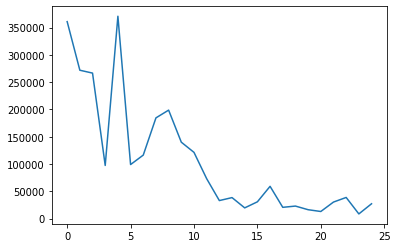

In [17]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    cnnlstm_multiclass_face_model = CNNLSTM(n_features, n_length, n_outputs)
    history = cnnlstm_multiclass_face_model.train(X_train, y_train, X_val, y_val, epochs, batch_size, class_weight)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [18]:
y_pred = cnnlstm_multiclass_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = cnnlstm_multiclass_face_model.evaluate(X_test, y_test)
cnn_auc.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 26.47% 
Balanced Accuracy: 12.01% 
ROC/AUC: 0.59 
Precision: 0.26 
Recall: 0.25 
F1 score: 0.11


#### RCNN

In [19]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(448, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results
    
    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 2s - loss: 48.5608 - accuracy: 0.1785 - auc_9: 0.6004 - precision_9: 0.1710 - recall_9: 0.1401 - f1_score: 0.1191 - val_loss: 6.5428 - val_accuracy: 0.0077 - val_auc_9: 0.5830 - val_precision_9: 0.2857 - val_recall_9: 0.0077 - val_f1_score: 0.0076 - 2s/epoch - 107ms/step
Epoch 2/25
17/17 - 0s - loss: 40.9058 - accuracy: 0.1190 - auc_9: 0.5077 - precision_9: 0.1493 - recall_9: 0.1017 - f1_score: 0.0815 - val_loss: 6.2370 - val_accuracy: 0.0115 - val_auc_9: 0.4499 - val_precision_9: 0.4286 - val_recall_9: 0.0115 - val_f1_score: 0.0097 - 369ms/epoch - 22ms/step
Epoch 3/25
17/17 - 0s - loss: 34.2788 - accuracy: 0.1267 - auc_9: 0.5460 - precision_9: 0.1804 - recall_9: 0.1132 - f1_score: 0.1031 - val_loss: 4.9866 - val_accuracy: 0.0115 - val_auc_9: 0.4917 - val_precision_9: 0.4286 - val_recall_9: 0.0115 - val_f1_score: 0.0096 - 356ms/epoch - 21ms/step
Epoch 4/25
17/17 - 0s - loss: 41.3992 - accuracy: 0.1036 - auc_9: 0.5479 - precision_9: 0.1335 - recall_9: 0.0825 - f1_scor

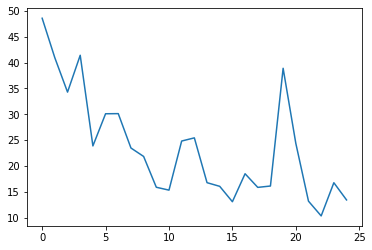

Epoch 1/25
17/17 - 2s - loss: 37.6240 - accuracy: 0.2380 - auc_10: 0.5887 - precision_10: 0.2836 - recall_10: 0.1823 - f1_score: 0.1428 - val_loss: 4.8390 - val_accuracy: 0.0766 - val_auc_10: 0.3789 - val_precision_10: 0.3333 - val_recall_10: 0.0077 - val_f1_score: 0.0220 - 2s/epoch - 94ms/step
Epoch 2/25
17/17 - 0s - loss: 18.8581 - accuracy: 0.1708 - auc_10: 0.5256 - precision_10: 0.2205 - recall_10: 0.1363 - f1_score: 0.1239 - val_loss: 3.3386 - val_accuracy: 0.4943 - val_auc_10: 0.7866 - val_precision_10: 0.6667 - val_recall_10: 0.0153 - val_f1_score: 0.1177 - 367ms/epoch - 22ms/step
Epoch 3/25
17/17 - 0s - loss: 10.4750 - accuracy: 0.3589 - auc_10: 0.6926 - precision_10: 0.3721 - recall_10: 0.1228 - f1_score: 0.1430 - val_loss: 3.1315 - val_accuracy: 0.1226 - val_auc_10: 0.5396 - val_precision_10: 0.3333 - val_recall_10: 0.0077 - val_f1_score: 0.0415 - 362ms/epoch - 21ms/step
Epoch 4/25
17/17 - 0s - loss: 14.4425 - accuracy: 0.1440 - auc_10: 0.5549 - precision_10: 0.2252 - recall_

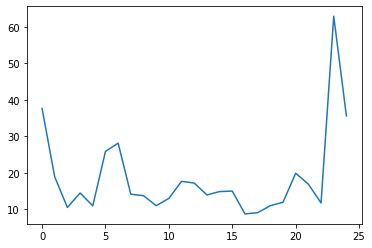

Epoch 1/25
17/17 - 2s - loss: 95.5745 - accuracy: 0.2011 - auc_11: 0.5905 - precision_11: 0.1919 - recall_11: 0.1552 - f1_score: 0.1065 - val_loss: 6.3748 - val_accuracy: 0.0885 - val_auc_11: 0.5877 - val_precision_11: 0.4286 - val_recall_11: 0.0115 - val_f1_score: 0.0376 - 2s/epoch - 94ms/step
Epoch 2/25
17/17 - 0s - loss: 39.6946 - accuracy: 0.1973 - auc_11: 0.5609 - precision_11: 0.1906 - recall_11: 0.1322 - f1_score: 0.1169 - val_loss: 4.0942 - val_accuracy: 0.0885 - val_auc_11: 0.5279 - val_precision_11: 0.4286 - val_recall_11: 0.0115 - val_f1_score: 0.0362 - 363ms/epoch - 21ms/step
Epoch 3/25
17/17 - 0s - loss: 25.7558 - accuracy: 0.1839 - auc_11: 0.6097 - precision_11: 0.2403 - recall_11: 0.1188 - f1_score: 0.1270 - val_loss: 4.0219 - val_accuracy: 0.0846 - val_auc_11: 0.6266 - val_precision_11: 0.2857 - val_recall_11: 0.0077 - val_f1_score: 0.0251 - 364ms/epoch - 21ms/step
Epoch 4/25
17/17 - 0s - loss: 17.2959 - accuracy: 0.1686 - auc_11: 0.6143 - precision_11: 0.2443 - recall_

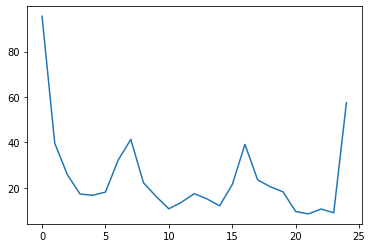

In [20]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    rcnn_multiclass_face_model = RCNN(n_features, n_length, n_outputs)
    history = rcnn_multiclass_face_model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [21]:
y_pred = rcnn_multiclass_face_model.predict(X_test)
_, acc, auc, precision, recall, f1 = rcnn_multiclass_face_model.evaluate(X_test, y_test)
rnn_auc.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 18.49% 
Balanced Accuracy: 15.46% 
ROC/AUC: 0.68 
Precision: 0.43 
Recall: 0.03 
F1 score: 0.07


## 3. Multimodal Early Fusion

### Dataset

In [22]:
X_train, X_test, y_train, y_test = load_fusioned_dataset()
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

(782, 1, 350, 60) (782, 7)
(238, 1, 350, 60) (238, 7)


### CNN + Bidirectional LSTM

In [23]:
class CNNLSTM():
    def __init__(self, n_length, n_features, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(128, activation='relu'))(flatten)
        dense = Dense(448, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 3s - loss: 380997.0625 - accuracy: 0.3167 - auc_12: 0.6039 - precision_12: 0.3167 - recall_12: 0.3167 - f1_score: 0.1250 - val_loss: 30171.8672 - val_accuracy: 0.5019 - val_auc_12: 0.7095 - val_precision_12: 0.5019 - val_recall_12: 0.5019 - val_f1_score: 0.1010 - 3s/epoch - 181ms/step
Epoch 2/25
17/17 - 1s - loss: 291469.1250 - accuracy: 0.4415 - auc_12: 0.6747 - precision_12: 0.4415 - recall_12: 0.4415 - f1_score: 0.1166 - val_loss: 39608.1445 - val_accuracy: 0.0805 - val_auc_12: 0.4628 - val_precision_12: 0.0805 - val_recall_12: 0.0805 - val_f1_score: 0.0358 - 515ms/epoch - 30ms/step
Epoch 3/25
17/17 - 1s - loss: 35710.5547 - accuracy: 0.0979 - auc_12: 0.4726 - precision_12: 0.0979 - recall_12: 0.0979 - f1_score: 0.0646 - val_loss: 29106.3672 - val_accuracy: 0.0383 - val_auc_12: 0.4364 - val_precision_12: 0.0383 - val_recall_12: 0.0383 - val_f1_score: 0.0435 - 672ms/epoch - 40ms/step
Epoch 4/25
17/17 - 1s - loss: 36988.3594 - accuracy: 0.1248 - auc_12: 0.4876 - pre

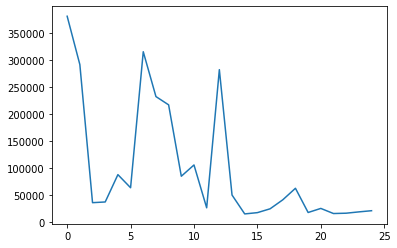

Epoch 1/25
17/17 - 3s - loss: 82293.7109 - accuracy: 0.1919 - auc_13: 0.5274 - precision_13: 0.1919 - recall_13: 0.1919 - f1_score: 0.1135 - val_loss: 149144.7656 - val_accuracy: 0.1188 - val_auc_13: 0.4860 - val_precision_13: 0.1188 - val_recall_13: 0.1188 - val_f1_score: 0.0321 - 3s/epoch - 190ms/step
Epoch 2/25
17/17 - 1s - loss: 361725.3438 - accuracy: 0.0979 - auc_13: 0.4726 - precision_13: 0.0979 - recall_13: 0.0979 - f1_score: 0.0825 - val_loss: 46016.9805 - val_accuracy: 0.1456 - val_auc_13: 0.5076 - val_precision_13: 0.1456 - val_recall_13: 0.1456 - val_f1_score: 0.0637 - 667ms/epoch - 39ms/step
Epoch 3/25
17/17 - 1s - loss: 274891.8125 - accuracy: 0.1536 - auc_13: 0.5045 - precision_13: 0.1536 - recall_13: 0.1536 - f1_score: 0.0923 - val_loss: 51682.6094 - val_accuracy: 0.1073 - val_auc_13: 0.4798 - val_precision_13: 0.1073 - val_recall_13: 0.1073 - val_f1_score: 0.0552 - 519ms/epoch - 31ms/step
Epoch 4/25
17/17 - 1s - loss: 314195.5312 - accuracy: 0.1113 - auc_13: 0.4828 - p

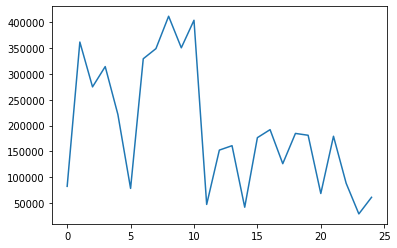

Epoch 1/25
17/17 - 3s - loss: 178911.3125 - accuracy: 0.0977 - auc_14: 0.4700 - precision_14: 0.0960 - recall_14: 0.0958 - f1_score: 0.0733 - val_loss: 74237.6953 - val_accuracy: 0.1500 - val_auc_14: 0.5042 - val_precision_14: 0.1500 - val_recall_14: 0.1500 - val_f1_score: 0.0418 - 3s/epoch - 180ms/step
Epoch 2/25
17/17 - 1s - loss: 291968.8750 - accuracy: 0.1954 - auc_14: 0.5302 - precision_14: 0.1954 - recall_14: 0.1954 - f1_score: 0.0993 - val_loss: 34249.6484 - val_accuracy: 0.0346 - val_auc_14: 0.4152 - val_precision_14: 0.0346 - val_recall_14: 0.0346 - val_f1_score: 0.0282 - 669ms/epoch - 39ms/step
Epoch 3/25
17/17 - 0s - loss: 123028.8750 - accuracy: 0.1034 - auc_14: 0.4672 - precision_14: 0.1034 - recall_14: 0.1034 - f1_score: 0.0603 - val_loss: 83660.0547 - val_accuracy: 0.0654 - val_auc_14: 0.4509 - val_precision_14: 0.0654 - val_recall_14: 0.0654 - val_f1_score: 0.0295 - 494ms/epoch - 29ms/step
Epoch 4/25
17/17 - 1s - loss: 123066.3047 - accuracy: 0.0556 - auc_14: 0.4472 - p

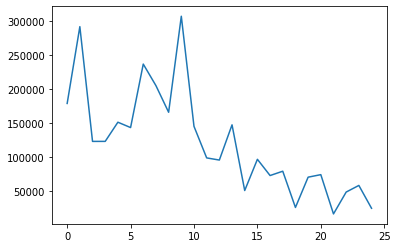

In [24]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = CNNLSTM(n_length, n_features, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [25]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
cnn_auc.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 16.81% 
Balanced Accuracy: 18.55% 
ROC/AUC: 0.50 
Precision: 0.17 
Recall: 0.17 
F1 score: 0.12


### RCNN

In [26]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(448, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results
    
    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 2s - loss: 38.7970 - accuracy: 0.2092 - auc_15: 0.5949 - precision_15: 0.1756 - recall_15: 0.0940 - f1_score: 0.1319 - val_loss: 13.0490 - val_accuracy: 0.0805 - val_auc_15: 0.4665 - val_precision_15: 0.0000e+00 - val_recall_15: 0.0000e+00 - val_f1_score: 0.0214 - 2s/epoch - 94ms/step
Epoch 2/25
17/17 - 0s - loss: 76.6585 - accuracy: 0.0845 - auc_15: 0.4967 - precision_15: 0.1038 - recall_15: 0.0787 - f1_score: 0.0804 - val_loss: 8.3957 - val_accuracy: 0.0881 - val_auc_15: 0.5402 - val_precision_15: 0.1429 - val_recall_15: 0.0038 - val_f1_score: 0.0310 - 353ms/epoch - 21ms/step
Epoch 3/25
17/17 - 0s - loss: 32.2257 - accuracy: 0.2534 - auc_15: 0.6610 - precision_15: 0.2639 - recall_15: 0.2457 - f1_score: 0.2012 - val_loss: 3.9316 - val_accuracy: 0.1456 - val_auc_15: 0.6526 - val_precision_15: 0.4286 - val_recall_15: 0.0115 - val_f1_score: 0.0443 - 356ms/epoch - 21ms/step
Epoch 4/25
17/17 - 0s - loss: 31.2795 - accuracy: 0.2687 - auc_15: 0.6455 - precision_15: 0.2462 

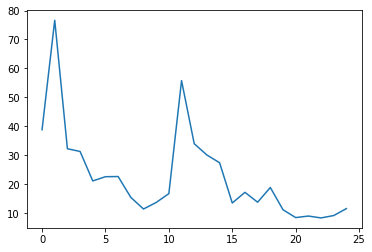

Epoch 1/25
17/17 - 2s - loss: 65.1307 - accuracy: 0.2457 - auc_16: 0.6013 - precision_16: 0.1967 - recall_16: 0.1152 - f1_score: 0.1324 - val_loss: 4.3008 - val_accuracy: 0.1226 - val_auc_16: 0.6596 - val_precision_16: 0.3333 - val_recall_16: 0.0077 - val_f1_score: 0.0415 - 2s/epoch - 93ms/step
Epoch 2/25
17/17 - 0s - loss: 24.2507 - accuracy: 0.2399 - auc_16: 0.6506 - precision_16: 0.2577 - recall_16: 0.2092 - f1_score: 0.1654 - val_loss: 3.7073 - val_accuracy: 0.1188 - val_auc_16: 0.6684 - val_precision_16: 0.6667 - val_recall_16: 0.0153 - val_f1_score: 0.0529 - 352ms/epoch - 21ms/step
Epoch 3/25
17/17 - 0s - loss: 19.8293 - accuracy: 0.2649 - auc_16: 0.6711 - precision_16: 0.2647 - recall_16: 0.1382 - f1_score: 0.1489 - val_loss: 2.5060 - val_accuracy: 0.4943 - val_auc_16: 0.7889 - val_precision_16: 0.6667 - val_recall_16: 0.0153 - val_f1_score: 0.1177 - 350ms/epoch - 21ms/step
Epoch 4/25
17/17 - 0s - loss: 12.0611 - accuracy: 0.3090 - auc_16: 0.6867 - precision_16: 0.3092 - recall_

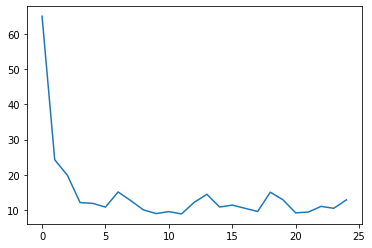

Epoch 1/25
17/17 - 2s - loss: 65.9761 - accuracy: 0.1245 - auc_17: 0.5377 - precision_17: 0.1460 - recall_17: 0.0766 - f1_score: 0.1031 - val_loss: 5.8827 - val_accuracy: 0.2038 - val_auc_17: 0.6143 - val_precision_17: 0.1429 - val_recall_17: 0.0038 - val_f1_score: 0.0594 - 2s/epoch - 114ms/step
Epoch 2/25
17/17 - 0s - loss: 39.1955 - accuracy: 0.2605 - auc_17: 0.6633 - precision_17: 0.2633 - recall_17: 0.1801 - f1_score: 0.1482 - val_loss: 6.4406 - val_accuracy: 0.4885 - val_auc_17: 0.8033 - val_precision_17: 0.4286 - val_recall_17: 0.0115 - val_f1_score: 0.1047 - 283ms/epoch - 17ms/step
Epoch 3/25
17/17 - 0s - loss: 63.3501 - accuracy: 0.2088 - auc_17: 0.5674 - precision_17: 0.1433 - recall_17: 0.0958 - f1_score: 0.1304 - val_loss: 7.2052 - val_accuracy: 0.4885 - val_auc_17: 0.6352 - val_precision_17: 0.4286 - val_recall_17: 0.0115 - val_f1_score: 0.1047 - 283ms/epoch - 17ms/step
Epoch 4/25
17/17 - 0s - loss: 28.0384 - accuracy: 0.2950 - auc_17: 0.5959 - precision_17: 0.2035 - recall

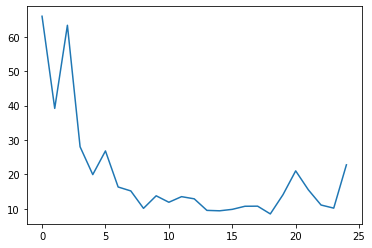

In [27]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = RCNN(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [28]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
rnn_auc.append(round(acc, 2))
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 0.84% 
Balanced Accuracy: 14.46% 
ROC/AUC: 0.44 
Precision: 0.01 
Recall: 0.01 
F1 score: 0.00


## 4. Multimodal Late Fusion

### Dataset

In [29]:
body_X_train, body_X_test, body_y_train, body_y_test = load_dataset('skeleton', fusion=True)
body_X = body_X_train.copy()
body_y = body_y_train.copy()

print(body_X_train.shape, body_y_train.shape)
print(body_X_test.shape, body_y_test.shape)

(782, 1, 350, 35) (782, 7)
(238, 1, 350, 35) (238, 7)


In [30]:
face_X_train, face_X_test, face_y_train, face_y_test = load_dataset('AUs')
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

(782, 1, 350, 25) (782, 7)
(238, 1, 350, 25) (238, 7)


In [31]:
n_length, body_features, face_features, n_outputs = face_X_train.shape[2], body_X_train.shape[-1], face_X_train.shape[-1], body_y_train.shape[1]

### CNN + Bidirectional LSTM

In [32]:
class fusioned_CNNLSTM():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation='relu'))(input_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_1)
        flatten_1 = TimeDistributed(Flatten())(maxpool_1)
        lstm_1 = LSTM(128)(flatten_1)
        dense_1 = Dense(448, activation='relu')(lstm_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation='relu'))(input_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_2)
        flatten_2 = TimeDistributed(Flatten())(maxpool_2)
        lstm_2 = LSTM(128)(flatten_2)
        dense_2 = Dense(448, activation='relu')(lstm_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='softmax')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

Epoch 1/25
17/17 - 4s - loss: 8.1167 - accuracy: 0.1228 - auc_18: 0.6723 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - f1_score: 0.0339 - val_loss: 1.8107 - val_accuracy: 0.1418 - val_auc_18: 0.7572 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.0425 - 4s/epoch - 244ms/step
Epoch 2/25
17/17 - 1s - loss: 8.0749 - accuracy: 0.1478 - auc_18: 0.7161 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - f1_score: 0.0483 - val_loss: 1.8679 - val_accuracy: 0.1379 - val_auc_18: 0.7057 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.0366 - 579ms/epoch - 34ms/step
Epoch 3/25
17/17 - 1s - loss: 7.9923 - accuracy: 0.2649 - auc_18: 0.6627 - precision_18: 0.0000e+00 - recall_18: 0.0000e+00 - f1_score: 0.0931 - val_loss: 1.9078 - val_accuracy: 0.4981 - val_auc_18: 0.6996 - val_precision_18: 0.0000e+00 - val_recall_18: 0.0000e+00 - val_f1_score: 0.1006 - 592ms/epoch - 35ms/step
Epoch 4/25
17/17 - 1s - loss: 7.8992 - accuracy: 0.2015 - au

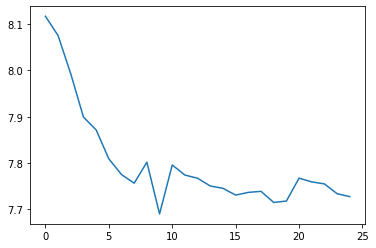

Epoch 1/25
17/17 - 4s - loss: 5.4787 - accuracy: 0.4319 - auc_19: 0.7900 - precision_19: 0.0000e+00 - recall_19: 0.0000e+00 - f1_score: 0.1124 - val_loss: 1.7258 - val_accuracy: 0.4866 - val_auc_19: 0.7995 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00 - val_f1_score: 0.1029 - 4s/epoch - 244ms/step
Epoch 2/25
17/17 - 1s - loss: 5.3936 - accuracy: 0.4952 - auc_19: 0.8074 - precision_19: 0.0000e+00 - recall_19: 0.0000e+00 - f1_score: 0.0972 - val_loss: 1.7389 - val_accuracy: 0.4828 - val_auc_19: 0.7988 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00 - val_f1_score: 0.1027 - 586ms/epoch - 34ms/step
Epoch 3/25
17/17 - 1s - loss: 5.3269 - accuracy: 0.4952 - auc_19: 0.7931 - precision_19: 0.0000e+00 - recall_19: 0.0000e+00 - f1_score: 0.0972 - val_loss: 1.7470 - val_accuracy: 0.4828 - val_auc_19: 0.7775 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00 - val_f1_score: 0.1031 - 590ms/epoch - 35ms/step
Epoch 4/25
17/17 - 1s - loss: 5.2741 - accuracy: 0.4971 - au

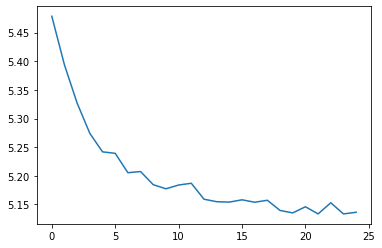

Epoch 1/25
17/17 - 4s - loss: 7.3350 - accuracy: 0.3276 - auc_20: 0.7651 - precision_20: 0.0000e+00 - recall_20: 0.0000e+00 - f1_score: 0.1212 - val_loss: 1.7859 - val_accuracy: 0.4885 - val_auc_20: 0.7874 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.0940 - 4s/epoch - 238ms/step
Epoch 2/25
17/17 - 1s - loss: 7.2112 - accuracy: 0.4981 - auc_20: 0.7972 - precision_20: 0.0000e+00 - recall_20: 0.0000e+00 - f1_score: 0.1048 - val_loss: 1.8104 - val_accuracy: 0.4846 - val_auc_20: 0.7865 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.0935 - 584ms/epoch - 34ms/step
Epoch 3/25
17/17 - 1s - loss: 7.2016 - accuracy: 0.4962 - auc_20: 0.7751 - precision_20: 0.0000e+00 - recall_20: 0.0000e+00 - f1_score: 0.1047 - val_loss: 1.8421 - val_accuracy: 0.4885 - val_auc_20: 0.7432 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_f1_score: 0.0940 - 579ms/epoch - 34ms/step
Epoch 4/25
17/17 - 1s - loss: 7.1363 - accuracy: 0.4962 - au

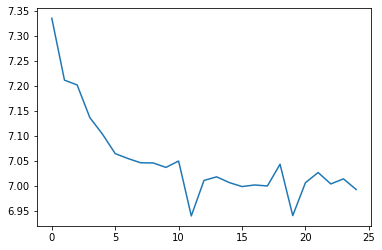

In [33]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_CNNLSTM(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [34]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
cnn_auc.append(round(auc, 2))
bal_acc = balanced_accuracy_score(body_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 1.26% 
Balanced Accuracy: 14.86% 
ROC/AUC: 0.57 
Precision: 0.00 
Recall: 0.00 
F1 score: 0.01


### RCNN

In [35]:
class fusioned_RCNN():
    def __init__(self, body_features, face_features, n_length, n_outputs):
        input_1 = Input(shape=(1, n_length, body_features))
        conv1d_1 = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_1)
        bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
        maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_1)
        flatten_1 = Flatten()(maxpool_1)
        dense_1 = Dense(448)(flatten_1)

        input_2 = Input(shape=(1, n_length, face_features))
        conv1d_2 = TimeDistributed(Conv1D(filters=448, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input_2)
        bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
        maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_2)
        flatten_2 = Flatten()(maxpool_2)
        dense_2 = Dense(448)(flatten_2)

        concat = Concatenate()([dense_1, dense_2])
        output = Dense(units=n_outputs, activation='softmax')(concat)
        model = Model(inputs=[input_1, input_2], outputs=[output])
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                            epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, body_X_test, face_X_test, y_test):
        results = self.model.evaluate([body_X_test, face_X_test], y_test, verbose=0)
        return results

    def predict(self, body_X_test, face_X_test):
        predictions = self.model.predict([body_X_test, face_X_test])
        return predictions

Epoch 1/25
17/17 - 2s - loss: 314.6357 - accuracy: 0.1843 - auc_21: 0.5346 - precision_21: 0.1855 - recall_21: 0.1766 - f1_score: 0.1167 - val_loss: 101.5328 - val_accuracy: 0.2452 - val_auc_21: 0.5748 - val_precision_21: 0.2452 - val_recall_21: 0.2452 - val_f1_score: 0.0891 - 2s/epoch - 130ms/step
Epoch 2/25
17/17 - 1s - loss: 383.8208 - accuracy: 0.2265 - auc_21: 0.5635 - precision_21: 0.2239 - recall_21: 0.2226 - f1_score: 0.1388 - val_loss: 88.0645 - val_accuracy: 0.2529 - val_auc_21: 0.5805 - val_precision_21: 0.2529 - val_recall_21: 0.2529 - val_f1_score: 0.0886 - 582ms/epoch - 34ms/step
Epoch 3/25
17/17 - 0s - loss: 235.7947 - accuracy: 0.2591 - auc_21: 0.5839 - precision_21: 0.2591 - recall_21: 0.2591 - f1_score: 0.1652 - val_loss: 240.6640 - val_accuracy: 0.1149 - val_auc_21: 0.4883 - val_precision_21: 0.1149 - val_recall_21: 0.1149 - val_f1_score: 0.0513 - 441ms/epoch - 26ms/step
Epoch 4/25
17/17 - 0s - loss: 127.6777 - accuracy: 0.2457 - auc_21: 0.5817 - precision_21: 0.2471

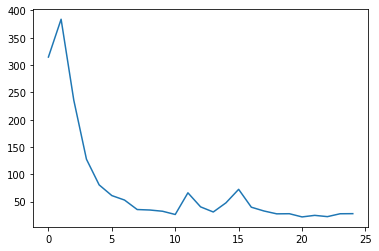

Epoch 1/25
17/17 - 3s - loss: 218.4581 - accuracy: 0.2841 - auc_22: 0.6008 - precision_22: 0.2923 - recall_22: 0.2783 - f1_score: 0.1713 - val_loss: 763.3982 - val_accuracy: 0.1034 - val_auc_22: 0.4770 - val_precision_22: 0.1034 - val_recall_22: 0.1034 - val_f1_score: 0.0271 - 3s/epoch - 148ms/step
Epoch 2/25
17/17 - 1s - loss: 113.7912 - accuracy: 0.2879 - auc_22: 0.6005 - precision_22: 0.2885 - recall_22: 0.2879 - f1_score: 0.1920 - val_loss: 221.5866 - val_accuracy: 0.0920 - val_auc_22: 0.4701 - val_precision_22: 0.0920 - val_recall_22: 0.0920 - val_f1_score: 0.0416 - 574ms/epoch - 34ms/step
Epoch 3/25
17/17 - 1s - loss: 104.5399 - accuracy: 0.3935 - auc_22: 0.6782 - precision_22: 0.3950 - recall_22: 0.3935 - f1_score: 0.2515 - val_loss: 149.4066 - val_accuracy: 0.1188 - val_auc_22: 0.4930 - val_precision_22: 0.1188 - val_recall_22: 0.1188 - val_f1_score: 0.0449 - 577ms/epoch - 34ms/step
Epoch 4/25
17/17 - 1s - loss: 86.1097 - accuracy: 0.3685 - auc_22: 0.6686 - precision_22: 0.3707

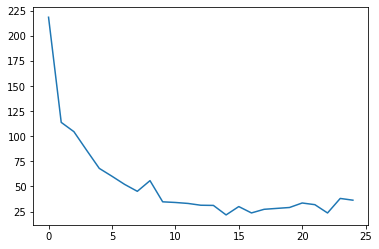

Epoch 1/25
17/17 - 2s - loss: 332.1616 - accuracy: 0.2318 - auc_23: 0.5716 - precision_23: 0.2356 - recall_23: 0.2280 - f1_score: 0.1661 - val_loss: 115.2371 - val_accuracy: 0.3462 - val_auc_23: 0.6179 - val_precision_23: 0.3462 - val_recall_23: 0.3462 - val_f1_score: 0.1384 - 2s/epoch - 124ms/step
Epoch 2/25
17/17 - 0s - loss: 167.2477 - accuracy: 0.2548 - auc_23: 0.5704 - precision_23: 0.2553 - recall_23: 0.2548 - f1_score: 0.1685 - val_loss: 344.6373 - val_accuracy: 0.1269 - val_auc_23: 0.4887 - val_precision_23: 0.1269 - val_recall_23: 0.1269 - val_f1_score: 0.0588 - 437ms/epoch - 26ms/step
Epoch 3/25
17/17 - 0s - loss: 87.9637 - accuracy: 0.3065 - auc_23: 0.6101 - precision_23: 0.3064 - recall_23: 0.3046 - f1_score: 0.3964 - val_loss: 165.4513 - val_accuracy: 0.0962 - val_auc_23: 0.4739 - val_precision_23: 0.0962 - val_recall_23: 0.0962 - val_f1_score: 0.0524 - 440ms/epoch - 26ms/step
Epoch 4/25
17/17 - 0s - loss: 149.1981 - accuracy: 0.3410 - auc_23: 0.6426 - precision_23: 0.3417

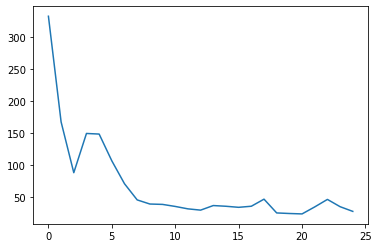

In [36]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    body_y_train, body_y_val = body_y[train_index], body_y[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    face_y_train, face_y_val = face_y[train_index], face_y[val_index]
    model = fusioned_RCNN(body_features, face_features, n_length, n_outputs)
    history = model.train(body_X_train, face_X_train, body_y_train, body_X_val, face_X_val, face_y_val, epochs, batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [37]:
y_pred = model.predict(body_X_test, face_X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(body_X_test, face_X_test, body_y_test)
rnn_auc.append(round(auc, 2))
bal_acc = balanced_accuracy_score(body_y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 18.07% 
Balanced Accuracy: 15.25% 
ROC/AUC: 0.51 
Precision: 0.18 
Recall: 0.18 
F1 score: 0.11


### Ensemble

In [38]:
class KerasMember():
    def __init__(self, name=None, keras_model=None, train_batches=None,
                 val_batches=None, submission_probs=None, keras_modelpath=None,
                 keras_kwargs={}):
        assert(name is not None)
        self.name = name
        self.model = keras_model
        self.submission_probs = submission_probs
        # Initialize Params
        self.val_probs = None
        self.train_probs = None
        self.val_classes = None
        self.train_classes = None
        if (keras_model is None) and (keras_modelpath is not None):
            self.load_kerasmodel(self.keras_modelpath, self.keras_kwargs)
        if train_batches is not None:
            self._calculate_train_predictions(train_batches)
        if val_batches is not None:
            self._calculate_val_predictions(val_batches)

    def _test_datatuple(self, datatuple):
        assert(len(datatuple) == 2)
        assert(datatuple[0].shape[0] == datatuple[1].shape[0])

    def _calculate_predictions(self, batches):
        if hasattr(batches, 'shuffle'):
            batches.reset()
            batches.shuffle = False
        if type(batches) is tuple:
            self._test_datatuple(batches)
            return self.model.predict(batches[0])
        return self.model.predict_generator(
            batches, steps=(batches.n // batches.batch_size) + 1, verbose=1)

    def _calculate_val_predictions(self, val_batches):
        if type(val_batches) is tuple:
            self.val_classes = val_batches[1]
        elif hasattr(val_batches, 'classes'):
            self.val_classes = np.array(val_batches.classes)
        elif hasattr(val_batches, 'y'):
            self.val_classes = np.array(val_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.val_probs = self._calculate_predictions(val_batches)
        return self.val_probs

    def _calculate_train_predictions(self, train_batches):
        if type(train_batches) is tuple:
            self.train_classes = train_batches[1]
        elif hasattr(train_batches, 'classes'):
            self.train_classes = np.array(train_batches.classes)
        elif hasattr(train_batches, 'y'):
            self.train_classes = np.array(train_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.train_probs = self._calculate_predictions(train_batches)
        return self.train_probs


def _calculate_metric(y_true, y_pred, metric=None):
    if metric is None:
        metric = roc_auc_score
    y_t = y_true
    y_p = y_pred
    if metric == roc_auc_score:
        return metric(y_t, y_p, multi_class='ovo')
    if y_true.ndim > 1:
        y_t = np.argmax(y_true, axis=1)
    if y_pred.ndim > 1:
        y_p = np.argmax(y_pred, axis=1)
    if metric is precision_recall_fscore_support:
        return precision_recall_fscore_support(y_t, y_p, average='macro')
    return metric(y_t, y_p)

class DirichletEnsemble():
    def __init__(self, N=10000, metric=None, maximize=True):
        self.n = N
        self.metric = metric
        if metric is None:
            self.metric = roc_auc_score
        self.maximize = maximize
        # Initialize Parameters:
        self.members = []
        self.bestweights = []
        self.probabilities = None
        self._nmembers = 0
        self.bestscore = float("-inf") if maximize else float("inf")
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.fitted = False

    def add_members(self, members):
        for member in members:
            self.add_member(member)

    def add_member(self, member):
        self.members.append(member)
        self._nmembers += 1

    def fit(self, verbose=False):
        assert(len(self.members) > 1)
        val_classes = self.members[0].val_classes
        best_ensemble_score = float("-inf") if self.maximize else float("inf")
        best_ensemble_accuracy = 0
        best_ensemble_p = 0
        best_ensemble_r = 0
        best_ensemble_f1 = 0
        rsbest = None
        for i in range(self.n):
            rs = np.random.dirichlet(np.ones(self._nmembers), size=1)[0]
            preds = np.sum(np.array([self.members[i].val_probs * rs[i]
                                     for i in range(self._nmembers)]), axis=0)
            ensemble_score = _calculate_metric(val_classes, preds)
            ensemble_accuracy = _calculate_metric(val_classes, preds, accuracy_score)
            ensemble_prf1 = _calculate_metric(val_classes, preds, precision_recall_fscore_support)
            ensemble_p = ensemble_prf1[0]
            ensemble_r = ensemble_prf1[1]
            ensemble_f1 = ensemble_prf1[2]
            max_flag = self.maximize and ensemble_score > best_ensemble_score
            min_flag = not(
                self.maximize) and ensemble_score < best_ensemble_score
            if max_flag or min_flag:
                if verbose:
                    print(ensemble_score, i, rs) 
                best_ensemble_score = ensemble_score
                rsbest = rs
            if ensemble_accuracy > best_ensemble_accuracy:
                if verbose:
                    print(ensemble_accuracy, i, rs) 
                best_ensemble_accuracy = ensemble_accuracy
            if ensemble_p > best_ensemble_p:
                if verbose:
                    print(ensemble_p, i, rs) 
                best_ensemble_p = ensemble_p
            if ensemble_r > best_ensemble_r:
                if verbose:
                    print(ensemble_r, i, rs) 
                best_ensemble_r = ensemble_r
            if ensemble_f1 > best_ensemble_f1:
                if verbose:
                    print(ensemble_f1, i, rs) 
                best_ensemble_f1 = ensemble_f1
        self.bestweights = rsbest
        self.bestscore = best_ensemble_score
        self.accuracy = best_ensemble_accuracy
        self.precision = best_ensemble_p
        self.recall = best_ensemble_r
        self.f1 = best_ensemble_f1

    def predict(self):
        self.probabilities = np.sum(np.array([self.bestweights[i] *
                                              self.members[i].submission_probs
                                              for i in range(self._nmembers)]),
                                    axis=0)
        return self.probabilities
        
    def describe(self):
        for i in range(self._nmembers):
            member = self.members[i]
            text = member.name + " (weight: {:1.4f})".format(self.bestweights[i])
            print(text)
        print("Accuracy: {:1.2f}% - ROC/AUC: {:1.2f} - Precision: {:1.2f} - Recall: {:1.2f} - F1 score: {:1.2f}".format(
            self.accuracy * 100, self.bestscore, self.precision, self.recall, self.f1))
        return self.bestscore

In [39]:
cnnlstm_body_member = KerasMember(name="CNN + Bidirectional LSTM Body Model", keras_model=cnnlstm_multiclass_body_model, train_batches=(body_X_train, body_y_train), val_batches=(body_X_test, body_y_test))
rcnn_body_member = KerasMember(name="RCNN Body Model", keras_model=rcnn_multiclass_body_model, train_batches=(body_X_train, body_y_train), val_batches=(body_X_test, body_y_test))
cnnlstm_face_member = KerasMember(name="CNN + Bidirectional LSTM Face Model", keras_model=cnnlstm_multiclass_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))
rcnn_face_member = KerasMember(name="RCNN Face Model", keras_model=rcnn_multiclass_face_model, train_batches=(face_X_train, face_y_train), val_batches=(face_X_test, face_y_test))

In [40]:
dirichletEnsemble = DirichletEnsemble()
dirichletEnsemble.add_member(cnnlstm_body_member)
dirichletEnsemble.add_member(rcnn_body_member)
dirichletEnsemble.add_member(cnnlstm_face_member)
dirichletEnsemble.add_member(rcnn_face_member)
dirichletEnsemble.fit()

In [41]:
e = dirichletEnsemble.describe()
cnn_auc.append(round(e, 2))
rnn_auc.append(0)

CNN + Bidirectional LSTM Body Model (weight: 0.1301)
RCNN Body Model (weight: 0.0186)
CNN + Bidirectional LSTM Face Model (weight: 0.0025)
RCNN Face Model (weight: 0.8488)
Accuracy: 31.09% - ROC/AUC: 0.65 - Precision: 0.19 - Recall: 0.19 - F1 score: 0.15


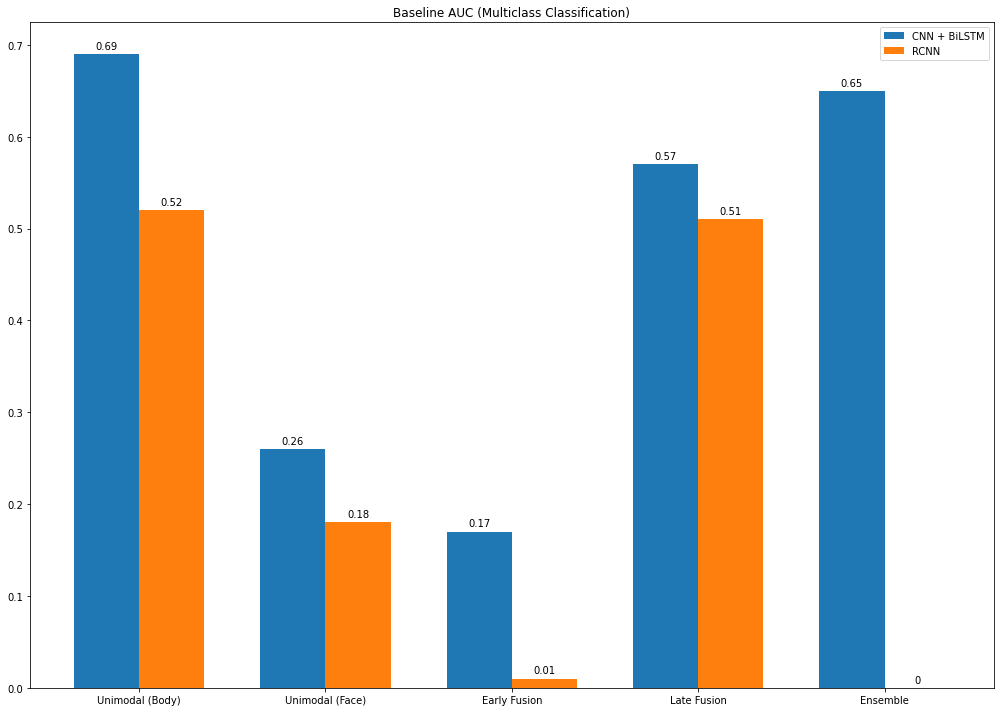

In [42]:
labels = ['Unimodal (Body)', 'Unimodal (Face)', 'Early Fusion', 'Late Fusion', 'Ensemble']
men_means = cnn_auc
women_means = rnn_auc

x = np.arange(len(labels)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, men_means, width, label='CNN + BiLSTM')
rects2 = ax.bar(x + width/2, women_means, width, label='RCNN')

ax.set_title('Baseline AUC (Multiclass Classification)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()